In [2]:
import matplotlib
%matplotlib inline
import random
import scipy.stats as stats
import pandas as pd
import numpy
import copy
import json
import ast
import math
import itertools
import scipy.stats as stats
import matplotlib.pyplot as pl
from operator import itemgetter, attrgetter, methodcaller
from scipy.stats import poisson
from docx import Document
from docx.text.run import Font, Run
from docx.dml.color import ColorFormat
from docx.shared import RGBColor


'''
The multinomial CDF function is the implementation of Levin's "Representaion of Multinomial Cumulative Distribution Function"

G:= Number of total groups (including non-protected)
k:= Position
p:= Array of probabilities of each group to be selected
tau_p:= Array of number of protected items

EXAMPLE:
Groups: ["White"(NP), "Black"(P), "Asian"(P), "Hispanic"(P)]
k: 30
p: [0.4, 0.3, 0.2, 0.1]
tau_p: [k, 10, 5, 3]
The ranking is fair if multinomCDF(4, 30, p, tau_p) > a = 0.1 
'''

def multinomCDF_log(G, k, p, tau_p):
    s = float(k);
    log_cdf = -poisson.logpmf(k,s);
    gamma1 = 0.0;
    gamma2 = 0.0;
    sum_s2 = 0.0;
    sum_mu = 0.0;
    
    # P(W=k)
    for i in range(0,G):
        sp = s*p[i];
        
        pcdf = poisson.cdf(tau_p[i],sp);
        log_cdf += numpy.log(pcdf);
        
        mu = sp*(1-poisson.pmf(tau_p[i],sp)/pcdf);
        s2 = mu-(tau_p[i]-mu)*(sp-mu);
        
        mr = tau_p[i];
        mf2 = sp*mu-mr*(sp-mu);
        
        mr *= tau_p[i]-1;
        mf3 = sp*mf2-mr*(sp-mu);
        
        mr *= tau_p[i]-2;
        mf4 = sp*mf3-mr*(sp-mu);
        
        mu2 = mf2+mu*(1-mu);
        mu3 = mf3+mf2*(3-3*mu)+mu*(1+mu*(-3+2*mu));
        mu4 = mf4+mf3*(6-4*mu)+mf2*(7+mu*(-12+6*mu))+mu*(1+mu*(-4+mu*(6-3*mu)));
        
        gamma1 += mu3;
        gamma2 += mu4-3*s2*s2;
        sum_mu += mu;
        sum_s2 += s2; 
    sp = numpy.sqrt(sum_s2);
    gamma1 /= sum_s2*sp;
    gamma2 /= sum_s2*sum_s2;
    
    x = (k-sum_mu)/sp;
    x2 = x*x;
    
    PWN = (-x2/2
    +numpy.log(1+gamma1/6*x*(x2-3)+gamma2/24*(x2*x2-6*x2+3)
    +gamma1*gamma1/72*(((x2-15)*x2+45)*x2-15))
    -numpy.log(2*math.pi)/2 -numpy.log(sp));
    
    log_cdf += PWN;
    return log_cdf;

def multinomCDF(G, k, p, tau_p):
    return numpy.exp(multinomCDF_log(G, k, p, tau_p ));

"""
To find a continuous multinomial icdf solution from a solution space.
Used for the Ranking Algorithm.
If the multinomial_CDF with tau alreay results in the value > a, return tau.
Else calculate the multinomial_CDF of tau in each case when each element of tau is increased by 1.
Compare the value and take the tau that produces the closest multinomial_CDF to a, which is also > a.

For example, initial tau: [0, 0, 0, 0]
if: 
    multinomial_CDF(G, k, p, tau) > a, return tau
else:
    compare:
        multinomial_CDF(G, k, p, [1, 0, 0, 0])
        multinomial_CDF(G, k, p, [0, 1, 0, 0])
        multinomial_CDF(G, k, p, [0, 0, 1, 0])
        multinomial_CDF(G, k, p, [0, 0, 0, 1])
    and take the increased tau with its multinomial_CDF > a and closest to a    

"""
def multinomial_icdf_continuous(G, k, p, a, tau):
    tau_p = [k] + list(tau);
    temp = copy.copy(tau_p)
    cdf = multinomCDF(G, k, p, tau_p)
    new_cdf = 0;
    initial = 1;
    not_fulfilled = 0;
    
    if(cdf > a):
        return tau_p;
    for i in range(len(tau_p)-1):
        temp[i+1] = temp[i+1]+1;
        if(initial == 1):
            tau_p = copy.copy(temp);
            cdf = multinomCDF(G, k, p, tau_p);
            initial = 0;
        else:
            new_cdf = multinomCDF(G, k, p, temp)
            if(new_cdf >= a and new_cdf >= cdf):
                tau_p = copy.copy(temp);
                cdf = multinomCDF(G, k, p, tau_p); 
        if(new_cdf >= a or cdf >= a):
            temp[i+1] = temp[i+1]-1    
    return tau_p

"""
Finds the target group which does not achieve the minimum target.
"""
def find_target(minimum_targets, count, categories):
    for i in range(len(minimum_targets)):
        if(minimum_targets[i] > count[i+1]):
                return categories[i+1];  

def find_achieved_target(minimum_targets, count, categories):
    for i in range(len(minimum_targets)):
        if(minimum_targets[i] < count[i+1]):
                return categories[i+1];             

def get_num_categories(attributeNamesAndCategories):
    num_categories = 1
    for i in attributeNamesAndCategories.items():
        num_categories *= i[1]
    return num_categories    
    
def determineGroups(attributeNamesAndCategories):
    elementSets = []
    groups = []
    for attr, cardinality in attributeNamesAndCategories.items():
        elementSets.append(list(range(0, cardinality)))

    groups = list(itertools.product(*elementSets))
    return groups

def get_minimum_targets(categories, p, alpha, k):
    positions = numpy.array(list(range(k))) + 1;
    minimum_targets = [];
    tau = numpy.zeros(len(categories)-1);

    for i in positions:
        tau_p = multinomial_icdf_continuous(len(p), i, p , alpha, tau)[1:]
        minimum_targets.append(numpy.array(tau_p));
        tau = copy.copy(tau_p);
    df = pd.DataFrame(data=(numpy.array(minimum_targets)).astype(int))
    df.columns = p[1:]
    df.index = numpy.array(range(k))+1
    df.to_html("minimum_target_table.html")    
    return minimum_targets    

def separate_groups(data_set, categories, attributeItems):
    num_categories = len(categories)
    separateByGroups = [[] for _ in range(num_categories)]
    
    for i in data_set:
        categorieList = []
        for j in attributeItems:
            categorieList.append(i[j[0]])
        separateByGroups[categories.index(tuple(categorieList))].append(i)
        categorieList = []
    return separateByGroups    

def plot(data_set,attributeNamesAndCategories, attributeQuality):
    colors = ['black', 'red', 'blue', 'green', 'yellow','slategray', 'darkseagreen', 'indigo']
    markers = ['-o','-<','-s','-+', '-d', '-h', '-p', '-8']
#     label=['Germany','Turkey','Greece','Italy','Spain','France']
    best = data_set[0][attributeQuality]
    categories = determineGroups(attributeNamesAndCategories)
    attributeItems = attributeNamesAndCategories.items()
    output_ranking_separated = separate_groups(data_set,categories, attributeItems)
    separateQualityByGroups = []
    fig = pl.figure(figsize=(20, 10))
    pl.subplot(211)
    round_2f = []
    for k in data_set:
        k[attributeQuality] = float(k[attributeQuality])/best
    
    for i in range(len(categories)):
        separateQualityByGroups.append([quality[attributeQuality] for quality in output_ranking_separated[i]])
        fit = stats.norm.pdf(separateQualityByGroups[i], numpy.mean(separateQualityByGroups[i]), numpy.std(separateQualityByGroups[i]))  
        pl.plot(separateQualityByGroups[i],fit,markers[i], markersize=6, label=categories[i], color=colors[i])
#         pl.plot(separateQualityByGroups[i],fit,markers[i], markersize=6, label=label[i], color=colors[i])
        pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
        round_2f.append([round(elem, 2) for elem in separateQualityByGroups[i]])
    pl.xlabel(attributeQuality+' (Quality)')
    pl.ylabel('Probability Density Function')

    pl.subplot(212)
    pl.hist(round_2f,30, histtype='bar', label=categories, color=colors[:len(categories)])    
#     pl.hist(round_2f,30, histtype='bar', label=label, color=colors[:len(categories)])    
    pl.xlabel(attributeQuality+' (Quality)')
    pl.ylabel('Frequency')
    pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
    pl.show()
    out_png = '../Plots/histo_plot.png'
    pl.savefig(out_png, dpi=100)    
    
def plot_scatter(data_set,attributeNamesAndCategories, attributeQuality):
#     label=['Germany','Turkey','Greece','Italy','Spain','France']
   
    colors = ['black', 'red', 'blue', 'green', 'yellow', 'magenta','slategray', 'darkseagreen', 'indigo']
    markers = ['o','<','s','>', 'd', 'x', 'h', 'p', '8']
    categories = determineGroups(attributeNamesAndCategories)
    attributeItems = attributeNamesAndCategories.items()
    separateQualityByGroups = []
    positionByGroups =[]
    for i in range(len(data_set)):
        data_set[i]['k']=i+1
    output_ranking_separated = separate_groups(data_set,categories, attributeItems)       
    fig = pl.figure(figsize=(6, 6), dpi=100)
    for i in range(len(categories)):
        separateQualityByGroups.append([quality[attributeQuality] for quality in output_ranking_separated[i]])
        positionByGroups.append([k['k'] for k in output_ranking_separated[i]])
        area = numpy.pi*4
        pl.scatter(positionByGroups[i], separateQualityByGroups[i], s=area, color=colors[i], alpha=0.5, label=categories[i], marker=markers[i])
#         pl.scatter(positionByGroups[i], separateQualityByGroups[i], s=area, color=colors[i], alpha=0.5, label=label[i], marker=markers[i])    
    pl.xlabel('Position (k)')
    pl.ylabel(attributeQuality+' (Quality)')
    pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
#     pl.ylim(0, 6.0)
    pl.show()              
    out_png = '../Plots/scatter.png'
    pl.savefig(out_png, dpi=100)   


"""
    - data_set: list of items in dictionary form, which specifies its group and quality
        ex) 
        [{'Gender': 0, 'Uni score': 0.5344585435},
         {'Gender': 2, 'Uni score': 1.0160173543},
         {'Gender': 0, 'Uni score': 0.4573686375},
         {'Gender': 1, 'Uni score': 0.6513702354}]
         
    - attributeNamesAndCategories: attributes that are being used to specify groups in the data_set and its number of categories
        ex)
        {"Gender": 4}
    
    - attributeQuality: the name of the attribute used for quality
        ex)
        "Uni score"
        
    - k: total length of the ranking
    
    - p: array of prbability, that each group could be selected into the ranking
        ex)
        [0.4,0.3,0.2,0.1]
            -> 0.4 for Gender: 0 (Non-protected)
            -> 0.3 for Gender: 1 (Protected)
            -> 0.2 for Gender: 2 (Protected)
            -> 0.1 for Gender: 3 (Protected)
            
    - alpha: Percentage of Type I error     

    - color_blind: specifies if this is color blind ranking or not. 
      True for generating color blind ranking. For applying fair ranking algorithm with different Protected Groups, False.
        
"""    
    
def multinomFair(data_set, attributeNamesAndCategories, attributeQuality, k, p, alpha, color_blind):
    categories = determineGroups(attributeNamesAndCategories)
    num_categories = len(categories)
    count = [0 for _ in range(num_categories)];
    ranking = []
    random_choice = ""
    chosen = 0
    num = 1
    swap = 0
    target = ()
    separateByGroups = [[] for _ in range(num_categories)]
    attributeItems = attributeNamesAndCategories.items()
    
    no_remaining_items = 0
        
    #array of the attribute names
    attributes = [i[0] for i in attributeItems]

    #saves the generated ranking in .txt file
    f = open('ranking.txt', 'w')
    
    # Separate the groups into each list
    separateByGroups = separate_groups(data_set, categories, attributeItems)
    
    # Sort the items in ascending order of their quality
    for i in range(num_categories):
        separateByGroups[i] = sorted(separateByGroups[i], key=lambda item: item[attributeQuality]) 
    
    if(color_blind):
        minimum_targets = numpy.zeros((k,num_categories-1))
    else:
        minimum_targets = get_minimum_targets(categories, p, alpha, k)
    
    for i in minimum_targets:
        for j in range(len(i)):
            if(i[j] > count[j+1] and chosen == 0):
                if(len(separateByGroups[j+1]) == 0):
                    no_remaining_items = 1
                    break
                item = separateByGroups[j+1].pop()
                ranking.append(item)
                f.write(str(item)+"\n")
                count[j+1] += 1;
                chosen = 1;
#                 print item
                if(any(count[a+1]<i[a] for a in range(len(i)))):
                    swap = len(ranking)-1;
                    # for edge case
                    while(any(count[a+1]<i[a] for a in range(len(i)))):
                        target = find_target(i, count, categories);
                        if(count[0] == 0):
                            achieved_target = find_achieved_target(i, count, categories);
                            if (all(ranking[swap][attributes[i]] == achieved_target[i] for i in range(len(attributes)))):
                                print "item to swap: ",ranking[swap]
                                separateByGroups[categories.index(achieved_target)].append(ranking[swap])
                                ranking = ranking[:swap] + ranking[swap+1 :]
                                ranking.append(separateByGroups[categories.index(target)].pop())
                                count[categories.index(target)] += 1
                                count[categories.index(achieved_target)] -= 1
                        else:    
                            print "Target group: ",target
                            if (all(ranking[swap][a] == 0 for a in attributes)):
                                separateByGroups[0].append(ranking[swap])
                                ranking = ranking[:swap] + ranking[swap+1 :]
                                ranking.append(separateByGroups[categories.index(target)].pop())
                                count[categories.index(target)] += 1
                                count[0] -= 1;
                        swap -= 1;    
        if(no_remaining_items == 1):
            break
        if(chosen == 0):
            heads = []
            first = 0
            duplicates=[]
            for x in separateByGroups:
                if (len(x) == 0):
                    heads.append(-100)                 
                else:
                    heads.append(x[len(x)-1][attributeQuality])  
            most_val = max(heads)
            # handle cases when more than one group with the best score exists
            for l in range(len(heads)):
                if (heads[l]==most_val):
                    duplicates.append(l)

            if(len(duplicates)>1):
                if(color_blind):
                    idx = numpy.random.choice(duplicates)
                else:
                    p_random = [p[r] for r in duplicates]
                    p_random = numpy.array(p_random)/sum(p_random)
                    idx = numpy.random.choice(duplicates, 1, p=p_random)[0]
            else:    
                idx= duplicates[0]
            item = separateByGroups[idx].pop()
#             print item
            f.write(str(item)+"\n")
            ranking.append(item);
            count[idx] += 1;
        print num, ": ", count, "Minimum Target: ",minimum_targets[num-1];
        f.write(str(num)+": "+str(count)+"Minimum Target: "+str(minimum_targets[num-1])+"\n")
        # print "CDF: ", multinomCDF(num_categories, num, p, [num]+count[1:])
        f.write("CDF: "+str(multinomCDF(num_categories, num, p, [num]+count[1:]))+"\n")
        num = num+1;
        chosen = 0;
    f.close()    
    rest = []
    best = ranking[0][attributeQuality]
    for i in separateByGroups:
        for j in i:
            rest.append(float(j[attributeQuality])/float(best))
    plot(ranking,attributeNamesAndCategories, attributeQuality)        
    plot_scatter(ranking,attributeNamesAndCategories, attributeQuality)
   
    for q in range(len(ranking)):
        ranking[q]['k']=q+1
        ranking[q]['Utility'] = (1.0/numpy.log(1+ q+1))*ranking[q][attributeQuality]
    
    # generates a .docx file that shows the generated ranking, in which each group is shown with different color.
    # the colors are set for maximum 6 different groups. If there are more than 6 groups, the colors have to be configured for those groups.     
    if(num_categories <=6):
        document = Document()
        document.add_heading("Output Ranking", 0)

        for idx in range(len(ranking)):
            if (all(ranking[idx][attributes[i]] == categories[0][i] for i in range(len(attributes)))):
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x3f, 0x2c, 0x36)
                print("\033[1;30m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[1][i] for i in range(len(attributes)))):
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xcc, 0x00, 0x00)
                print("\033[1;31m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[2][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x00, 0x66, 0xff)
                print("\033[1;34m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[3][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x00, 0x99, 0x33)
                print("\033[1;32m%s\033[1;m") % ranking[idx]   
            elif (all(ranking[idx][attributes[i]] == categories[4][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xFF, 0xCC, 0x33)
                print("\033[1;33m%s\033[1;m") % ranking[idx]   
            elif (all(ranking[idx][attributes[i]] == categories[5][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x99, 0x66, 0x00)
                print("\033[1;35m%s\033[1;m") % ranking[idx]   
            elif (all(ranking[idx][attributes[i]] == categories[6][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xff, 0x00, 0xff)
                print("\033[1;37m%s\033[1;m") % ranking[idx]
            elif (all(ranking[idx][attributes[i]] == categories[7][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xff, 0x00, 0xff)
                print("\033[1;41m%s\033[1;m") % ranking[idx]      
        document.save('output_ranking_different_color.docx')
        
    return ranking  

def parseDataset(data_set, attributeName, categories):
    json_data = open(data_set).read()
    data = numpy.array(json_data.split("\n"))
    data_set = []
    group_count = numpy.zeros(categories)
    
    f = open('properties.txt', 'w')
    
    for i in data:
        data_set.append(ast.literal_eval(i))
    
    for j in range(len(data_set)):
        data_set[j]['Index']=j+1
        for i in range(categories):
            if(data_set[j][attributeNames]==i):
                group_count[i] = group_count[i]+1
        
    for i in range(categories):
        f.write("Group "+str(i)+": "+str(group_count[i])+"\n")
        print "Group ",i,": ",group_count[i]
    
    f.write("Size of data set: "+str(len(data_set))+"\n")
    print "Size of data set: ", len(data_set)
    f.close()  

    return data_set     

# if __name__ == '__main__'
#     import argparse
#     parser = argparse.ArgumentParser(description="data_set, attributeNamesAndCategories, attributeQuality, k, p, alpha, color_blind")
#     parser.add_argument('--data_set', metavar='path', required=True,
#                        help='path to the data set JSON file')
#     parser.add_argument('--attributeNamesAndCategories', required=True,
#                        help='protected attribute name and size in dictionary')
#     parser.addargument('--attributeQuality', required=True)
#     parser.addargument('--k', required=True)
#     parser.addargument('--p', required=True)
#     parser.addargument('--alpha',required=True)
#     parser.addargument('--color_blind',required=True)
#     args = parser.parse_args()
    
#     data = parseDataset(args.data_set)
    
#     multinomFair(data_set=data, attributeNamesAndCategories=args.attributeNamesAndCategories,
#                  attributeQuality=args.attributeQuality, k=args.k, p=args.p, 
#                  alpha=args.alpha, color_blind=args.color_blind)

Group  0 :  18285.0
Group  1 :  99.0
Group  2 :  845.0
Group  3 :  1282.0
Group  4 :  488.0
Group  5 :  389.0
Group  6 :  293.0
Group  7 :  110.0
Size of data set:  21791
1 :  [0, 0, 0, 0, 0, 0, 1, 0] Minimum Target:  [ 0.  0.  0.  0.  0.  0.  0.]
2 :  [1, 0, 0, 0, 0, 0, 1, 0] Minimum Target:  [ 0.  0.  0.  0.  0.  0.  0.]
3 :  [1, 1, 0, 0, 0, 0, 1, 0] Minimum Target:  [ 1.  0.  0.  0.  0.  0.  0.]
4 :  [1, 1, 1, 0, 0, 0, 1, 0] Minimum Target:  [ 1.  0.  0.  0.  0.  1.  0.]
5 :  [1, 1, 1, 0, 0, 1, 1, 0] Minimum Target:  [ 1.  0.  0.  0.  1.  1.  0.]
6 :  [1, 1, 1, 0, 1, 1, 1, 0] Minimum Target:  [ 1.  0.  0.  1.  1.  1.  0.]
7 :  [1, 1, 1, 1, 1, 1, 1, 0] Minimum Target:  [ 1.  0.  1.  1.  1.  1.  0.]
8 :  [2, 1, 1, 1, 1, 1, 1, 0] Minimum Target:  [ 1.  0.  1.  1.  1.  1.  0.]
9 :  [3, 1, 1, 1, 1, 1, 1, 0] Minimum Target:  [ 1.  1.  1.  1.  1.  1.  0.]
10 :  [3, 2, 1, 1, 1, 1, 1, 0] Minimum Target:  [ 2.  1.  1.  1.  1.  1.  0.]
11 :  [4, 2, 1, 1, 1, 1, 1, 0] Minimum Target:  [ 2.  1.  

98 :  [25, 20, 10, 10, 11, 11, 11, 0] Minimum Target:  [ 20.  10.  10.  11.  11.  11.   0.]
99 :  [25, 20, 10, 11, 11, 11, 11, 0] Minimum Target:  [ 20.  10.  11.  11.  11.  11.   0.]
100 :  [25, 20, 11, 11, 11, 11, 11, 0] Minimum Target:  [ 20.  11.  11.  11.  11.  11.   0.]
101 :  [26, 20, 11, 11, 11, 11, 11, 0] Minimum Target:  [ 20.  11.  11.  11.  11.  11.   0.]
102 :  [26, 21, 11, 11, 11, 11, 11, 0] Minimum Target:  [ 21.  11.  11.  11.  11.  11.   0.]
103 :  [26, 22, 11, 11, 11, 11, 11, 0] Minimum Target:  [ 22.  11.  11.  11.  11.  11.   0.]
104 :  [27, 22, 11, 11, 11, 11, 11, 0] Minimum Target:  [ 22.  11.  11.  11.  11.  11.   0.]
105 :  [27, 22, 11, 12, 11, 11, 11, 0] Minimum Target:  [ 22.  11.  12.  11.  11.  11.   0.]
106 :  [27, 22, 11, 12, 11, 11, 12, 0] Minimum Target:  [ 22.  11.  12.  11.  11.  12.   0.]
107 :  [27, 22, 11, 12, 11, 12, 12, 0] Minimum Target:  [ 22.  11.  12.  11.  12.  12.   0.]
108 :  [28, 22, 11, 12, 11, 12, 12, 0] Minimum Target:  [ 22.  11.  12. 

193 :  [50, 39, 20, 21, 21, 21, 21, 0] Minimum Target:  [ 39.  20.  21.  21.  21.  21.   0.]
194 :  [51, 39, 20, 21, 21, 21, 21, 0] Minimum Target:  [ 39.  20.  21.  21.  21.  21.   0.]
195 :  [51, 39, 21, 21, 21, 21, 21, 0] Minimum Target:  [ 39.  21.  21.  21.  21.  21.   0.]
196 :  [51, 40, 21, 21, 21, 21, 21, 0] Minimum Target:  [ 40.  21.  21.  21.  21.  21.   0.]
197 :  [52, 40, 21, 21, 21, 21, 21, 0] Minimum Target:  [ 40.  21.  21.  21.  21.  21.   0.]
198 :  [52, 41, 21, 21, 21, 21, 21, 0] Minimum Target:  [ 41.  21.  21.  21.  21.  21.   0.]
199 :  [52, 41, 21, 21, 21, 21, 22, 0] Minimum Target:  [ 41.  21.  21.  21.  21.  22.   0.]
200 :  [52, 41, 21, 21, 21, 22, 22, 0] Minimum Target:  [ 41.  21.  21.  21.  22.  22.   0.]
201 :  [53, 41, 21, 21, 21, 22, 22, 0] Minimum Target:  [ 41.  21.  21.  21.  22.  22.   0.]
202 :  [53, 41, 21, 21, 22, 22, 22, 0] Minimum Target:  [ 41.  21.  21.  22.  22.  22.   0.]
203 :  [53, 41, 21, 22, 22, 22, 22, 0] Minimum Target:  [ 41.  21.  22

304 :  [81, 62, 32, 32, 32, 32, 33, 0] Minimum Target:  [ 62.  32.  32.  32.  32.  33.   0.]
305 :  [82, 62, 32, 32, 32, 32, 33, 0] Minimum Target:  [ 62.  32.  32.  32.  32.  33.   0.]
306 :  [82, 62, 32, 32, 32, 33, 33, 0] Minimum Target:  [ 62.  32.  32.  32.  33.  33.   0.]
307 :  [82, 62, 32, 32, 33, 33, 33, 0] Minimum Target:  [ 62.  32.  32.  33.  33.  33.   0.]
308 :  [82, 62, 32, 33, 33, 33, 33, 0] Minimum Target:  [ 62.  32.  33.  33.  33.  33.   0.]
309 :  [83, 62, 32, 33, 33, 33, 33, 0] Minimum Target:  [ 62.  32.  33.  33.  33.  33.   0.]
310 :  [83, 62, 33, 33, 33, 33, 33, 0] Minimum Target:  [ 62.  33.  33.  33.  33.  33.   0.]
311 :  [83, 63, 33, 33, 33, 33, 33, 0] Minimum Target:  [ 63.  33.  33.  33.  33.  33.   0.]
312 :  [84, 63, 33, 33, 33, 33, 33, 0] Minimum Target:  [ 63.  33.  33.  33.  33.  33.   0.]
313 :  [84, 64, 33, 33, 33, 33, 33, 0] Minimum Target:  [ 64.  33.  33.  33.  33.  33.   0.]
314 :  [84, 64, 33, 33, 33, 34, 33, 0] Minimum Target:  [ 64.  33.  33

392 :  [106, 80, 41, 41, 41, 41, 42, 0] Minimum Target:  [ 80.  41.  41.  41.  41.  42.   0.]
393 :  [106, 80, 41, 41, 41, 42, 42, 0] Minimum Target:  [ 80.  41.  41.  41.  42.  42.   0.]
394 :  [106, 80, 41, 41, 42, 42, 42, 0] Minimum Target:  [ 80.  41.  41.  42.  42.  42.   0.]
395 :  [107, 80, 41, 41, 42, 42, 42, 0] Minimum Target:  [ 80.  41.  41.  42.  42.  42.   0.]
396 :  [107, 80, 41, 42, 42, 42, 42, 0] Minimum Target:  [ 80.  41.  42.  42.  42.  42.   0.]
397 :  [107, 80, 42, 42, 42, 42, 42, 0] Minimum Target:  [ 80.  42.  42.  42.  42.  42.   0.]
398 :  [108, 80, 42, 42, 42, 42, 42, 0] Minimum Target:  [ 80.  42.  42.  42.  42.  42.   0.]
399 :  [108, 81, 42, 42, 42, 42, 42, 0] Minimum Target:  [ 81.  42.  42.  42.  42.  42.   0.]
400 :  [108, 82, 42, 42, 42, 42, 42, 0] Minimum Target:  [ 82.  42.  42.  42.  42.  42.   0.]
401 :  [108, 82, 42, 42, 42, 43, 42, 0] Minimum Target:  [ 82.  42.  42.  42.  43.  42.   0.]
402 :  [109, 82, 42, 42, 42, 43, 42, 0] Minimum Target:  [ 8

482 :  [131, 97, 50, 51, 51, 51, 51, 0] Minimum Target:  [ 97.  50.  51.  51.  51.  51.   0.]
483 :  [132, 97, 50, 51, 51, 51, 51, 0] Minimum Target:  [ 97.  50.  51.  51.  51.  51.   0.]
484 :  [132, 98, 50, 51, 51, 51, 51, 0] Minimum Target:  [ 98.  50.  51.  51.  51.  51.   0.]
485 :  [132, 98, 51, 51, 51, 51, 51, 0] Minimum Target:  [ 98.  51.  51.  51.  51.  51.   0.]
486 :  [132, 99, 51, 51, 51, 51, 51, 0] Minimum Target:  [ 99.  51.  51.  51.  51.  51.   0.]
487 :  [133, 99, 51, 51, 51, 51, 51, 0] Minimum Target:  [ 99.  51.  51.  51.  51.  51.   0.]
488 :  [133, 99, 51, 51, 51, 51, 52, 0] Minimum Target:  [ 99.  51.  51.  51.  51.  52.   0.]
489 :  [133, 99, 51, 51, 51, 52, 52, 0] Minimum Target:  [ 99.  51.  51.  51.  52.  52.   0.]
490 :  [134, 99, 51, 51, 51, 52, 52, 0] Minimum Target:  [ 99.  51.  51.  51.  52.  52.   0.]
491 :  [134, 99, 51, 51, 52, 52, 52, 0] Minimum Target:  [ 99.  51.  51.  52.  52.  52.   0.]
492 :  [134, 99, 51, 52, 52, 52, 52, 0] Minimum Target:  [ 9

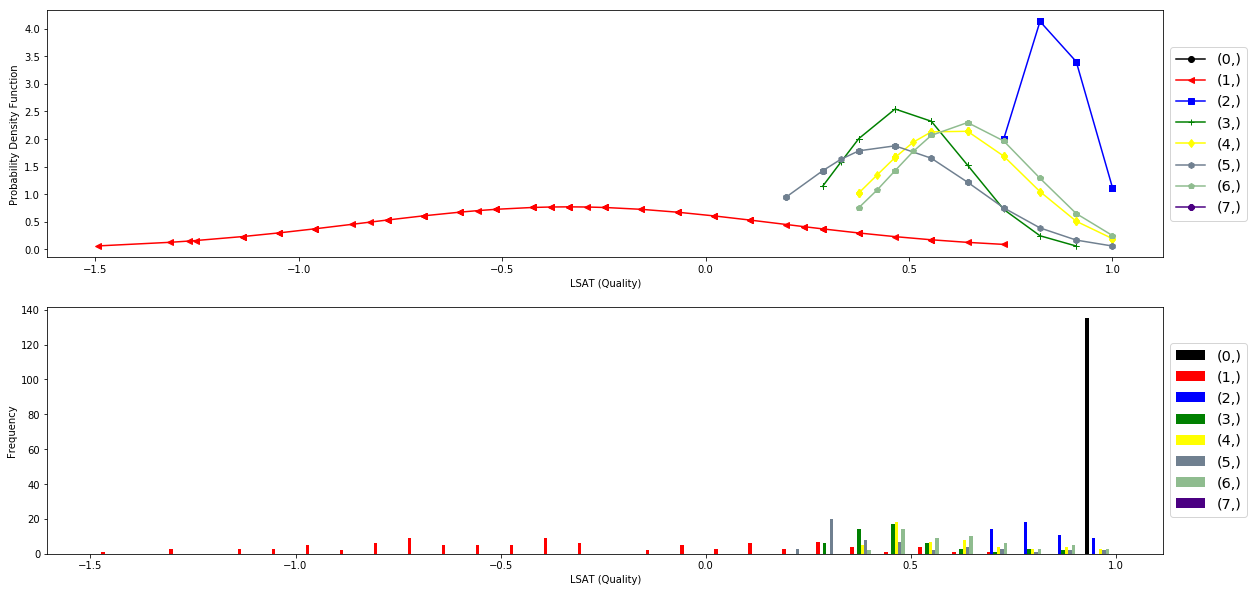

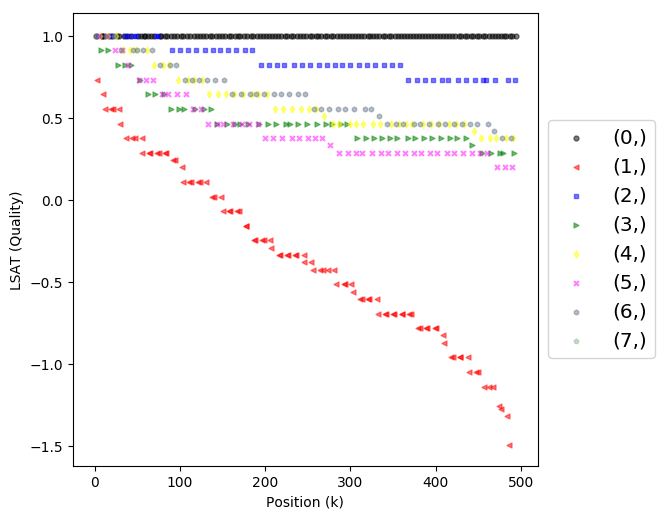

In [8]:
json_data = open('LSAT.json').read()
data = numpy.array(json_data.split("\n"))
data_set = []
group_num = 8
group_count = numpy.zeros(group_num)

for i in data:
    data_set.append(ast.literal_eval(i))

for j in range(len(data_set)):
    data_set[j]['Index']=j+1  
    if(data_set[j]['race']==0):
        group_count[0] = group_count[0]+1
    elif(data_set[j]['race']==1):
        group_count[1] = group_count[1]+1    
    elif(data_set[j]['race']==2):
        group_count[2] = group_count[2]+1    
    elif(data_set[j]['race']==3):
        group_count[3] = group_count[3]+1 
    elif(data_set[j]['race']==4):
        group_count[4] = group_count[4]+1 
    elif(data_set[j]['race']==5):
        group_count[5] = group_count[5]+1 
    elif(data_set[j]['race']==6):
        group_count[6] = group_count[6]+1 
    elif(data_set[j]['race']==7):
        group_count[7] = group_count[7]+1        
for i in range(group_num):
    print "Group ",i,": ",group_count[i]
print "Size of data set: ", len(data_set)

test_ranking = multinomFair(data_set, {'race':8}, 'LSAT',1000, [0.3,0.2, 0.1, 0.1,0.1,0.1,0.1, 0.0], 0.03, False)

1 :  [1, 0, 0, 0] Minimum Target:  [ 0.  0.  0.]
2 :  [2, 0, 0, 0] Minimum Target:  [ 0.  0.  0.]
3 :  [2, 1, 0, 0] Minimum Target:  [ 1.  0.  0.]
4 :  [3, 1, 0, 0] Minimum Target:  [ 1.  0.  0.]
5 :  [3, 1, 1, 0] Minimum Target:  [ 1.  1.  0.]
6 :  [3, 2, 1, 0] Minimum Target:  [ 2.  1.  0.]
7 :  [4, 2, 1, 0] Minimum Target:  [ 2.  1.  0.]
8 :  [4, 2, 1, 1] Minimum Target:  [ 2.  1.  1.]
9 :  [4, 2, 2, 1] Minimum Target:  [ 2.  2.  1.]
10 :  [5, 2, 2, 1] Minimum Target:  [ 2.  2.  1.]
11 :  [5, 3, 2, 1] Minimum Target:  [ 3.  2.  1.]
12 :  [6, 3, 2, 1] Minimum Target:  [ 3.  2.  1.]
13 :  [6, 4, 2, 1] Minimum Target:  [ 4.  2.  1.]
14 :  [6, 4, 3, 1] Minimum Target:  [ 4.  3.  1.]
15 :  [7, 4, 3, 1] Minimum Target:  [ 4.  3.  1.]
16 :  [7, 4, 3, 2] Minimum Target:  [ 4.  3.  2.]
17 :  [7, 5, 3, 2] Minimum Target:  [ 5.  3.  2.]
18 :  [8, 5, 3, 2] Minimum Target:  [ 5.  3.  2.]
19 :  [8, 5, 4, 2] Minimum Target:  [ 5.  4.  2.]
20 :  [9, 5, 4, 2] Minimum Target:  [ 5.  4.  2.]
21 :  [9,

185 :  [74, 54, 37, 20] Minimum Target:  [ 54.  37.  20.]
186 :  [74, 55, 37, 20] Minimum Target:  [ 55.  37.  20.]
187 :  [74, 55, 38, 20] Minimum Target:  [ 55.  38.  20.]
188 :  [75, 55, 38, 20] Minimum Target:  [ 55.  38.  20.]
189 :  [75, 56, 38, 20] Minimum Target:  [ 56.  38.  20.]
190 :  [76, 56, 38, 20] Minimum Target:  [ 56.  38.  20.]
191 :  [76, 57, 38, 20] Minimum Target:  [ 57.  38.  20.]
192 :  [76, 57, 39, 20] Minimum Target:  [ 57.  39.  20.]
193 :  [77, 57, 39, 20] Minimum Target:  [ 57.  39.  20.]
194 :  [77, 57, 39, 21] Minimum Target:  [ 57.  39.  21.]
195 :  [78, 57, 39, 21] Minimum Target:  [ 57.  39.  21.]
196 :  [78, 58, 39, 21] Minimum Target:  [ 58.  39.  21.]
197 :  [78, 58, 40, 21] Minimum Target:  [ 58.  40.  21.]
198 :  [79, 58, 40, 21] Minimum Target:  [ 58.  40.  21.]
199 :  [79, 59, 40, 21] Minimum Target:  [ 59.  40.  21.]
200 :  [80, 59, 40, 21] Minimum Target:  [ 59.  40.  21.]
201 :  [80, 59, 41, 21] Minimum Target:  [ 59.  41.  21.]
202 :  [80, 60

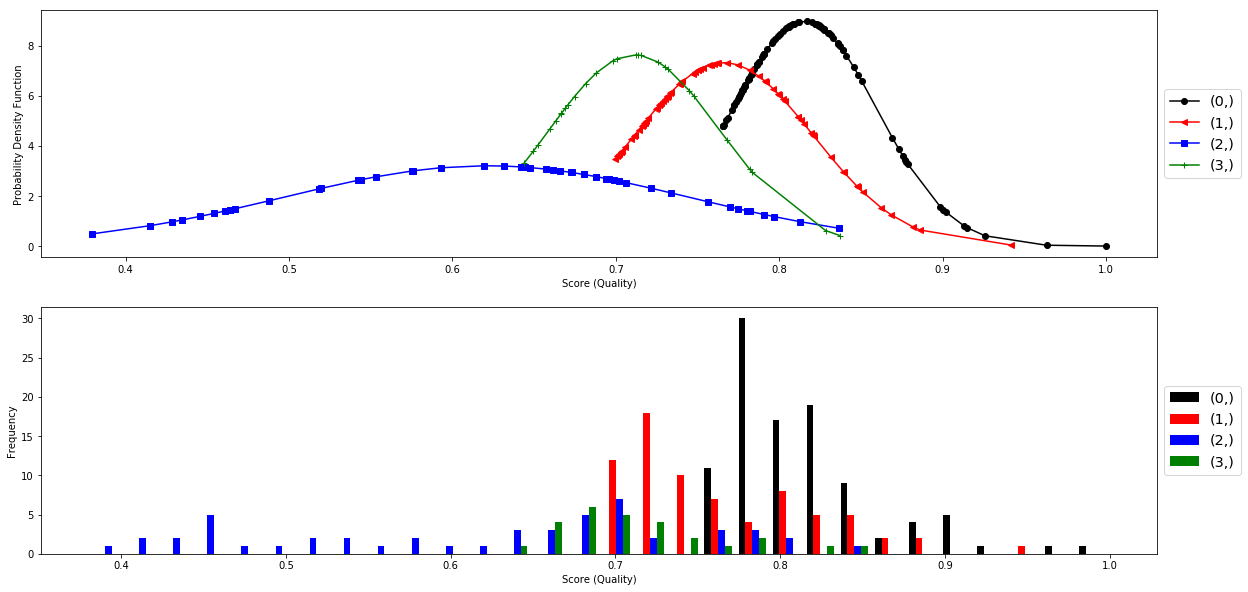

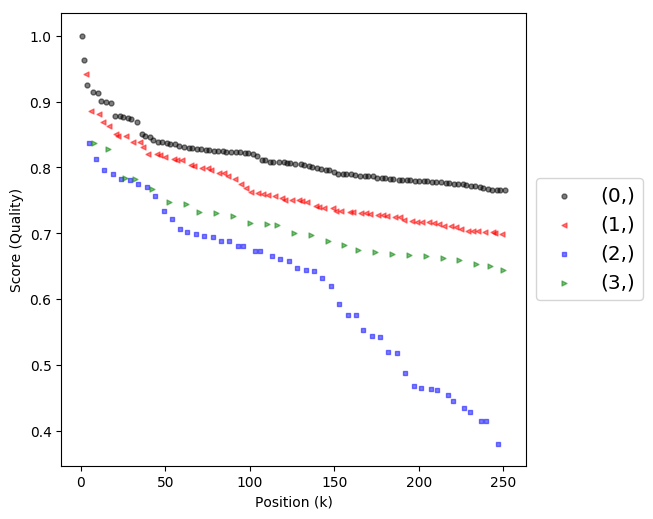

{'k': 1, 'Score': 1.0, 'Group': 0, 'Utility': 1.4426950408889634}
{'k': 2, 'Score': 0.9634788985234082, 'Group': 0, 'Utility': 0.87699628746322411}
{'k': 3, 'Score': 0.9420066211780169, 'Group': 1, 'Utility': 0.67951414042904668}
{'k': 4, 'Score': 0.9257552084212175, 'Group': 0, 'Utility': 0.57520405184261703}
{'k': 5, 'Score': 0.8366075105736831, 'Group': 2, 'Utility': 0.46691954190375745}
{'k': 6, 'Score': 0.8861122927489402, 'Group': 1, 'Utility': 0.45537163839713968}
{'k': 7, 'Score': 0.9148915339734488, 'Group': 0, 'Utility': 0.43996982633826376}
{'k': 8, 'Score': 0.8370719344477783, 'Group': 3, 'Utility': 0.3809678551213882}
{'k': 9, 'Score': 0.8125237519389911, 'Group': 2, 'Utility': 0.35287458188243037}
{'k': 10, 'Score': 0.9129079211152771, 'Group': 0, 'Utility': 0.3807121734928412}
{'k': 11, 'Score': 0.8818414203072478, 'Group': 1, 'Utility': 0.35487909390176969}
{'k': 12, 'Score': 0.9017068827878809, 'Group': 0, 'Utility': 0.35154958524416119}
{'k': 13, 'Score': 0.8683481684

{'k': 145, 'Score': 0.796324154980081, 'Group': 0, 'Utility': 0.15978872640375216}
{'k': 146, 'Score': 0.6879750565741418, 'Group': 3, 'Utility': 0.13785880173931403}
{'k': 147, 'Score': 0.7955076977461527, 'Group': 0, 'Utility': 0.15919029534179507}
{'k': 148, 'Score': 0.6193275454344317, 'Group': 2, 'Utility': 0.12376782394698663}
{'k': 149, 'Score': 0.738706618794179, 'Group': 1, 'Utility': 0.14742773629215336}
{'k': 150, 'Score': 0.7926302879982128, 'Group': 0, 'Utility': 0.15798008358676507}
{'k': 151, 'Score': 0.7337722563792838, 'Group': 1, 'Utility': 0.14605686845746868}
{'k': 152, 'Score': 0.7907358270617068, 'Group': 0, 'Utility': 0.15719025647827287}
{'k': 153, 'Score': 0.5928205147010532, 'Group': 2, 'Utility': 0.11769428094617823}
{'k': 154, 'Score': 0.7331133382021634, 'Group': 1, 'Utility': 0.14536021081046255}
{'k': 155, 'Score': 0.7906918224172124, 'Group': 0, 'Utility': 0.15657710265047178}
{'k': 156, 'Score': 0.6814721669794753, 'Group': 3, 'Utility': 0.1347782906951

In [9]:
json_data = open('german_credit.json').read()
data = numpy.array(json_data.split("\n"))
data_set = []
for i in data:
    data_set.append(ast.literal_eval(i))
attribute = {'Group':4}  

test_ranking = multinomFair(data_set, {'Group':4}, 'Score',500, [0.4,0.3,0.2,0.1], float(0.1), False)